# Práctica 2: Procesamiento del Lenguaje Natural

__Fecha de entrega: 17 de abril de 2022__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN. La práctica consta de 2 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

In [1]:
RANDOM_STATE = 22

# Apartado 2: Recuperación de información

__Número de grupo: 15__

__Nombres de los estudiantes: Javier Sande Ríos y Mario Sanz Guerrero__

## 1) Carga del conjunto de datos

El fichero `BBC News.csv` contiene noticias clasificadas en 5 categorías diferentes. 

Carga los datos en un dataframe teniendo en cuenta que la columna `ArticleId` es un identificador de la noticia y por lo tanto no lo vamos a usar. 

Estudia el tamaño del conjunto de datos y la proporción de noticias que pertenecen a cada una de las categorías.

Crea una partición estratificada de los datos dejando el 80% para entrenamiento y el 20% restante para test usando la función `train_test_split` de sklearn. 

#### Solución:

In [2]:
import numpy as np
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df = pd.read_csv('BBC News.csv')
df

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [4]:
df['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

<AxesSubplot:>

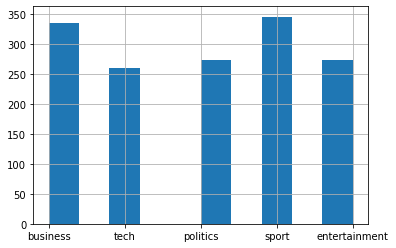

In [5]:
df['Category'].hist()

Como podemos ver al hacer la funcion `value_counts()` y al ver el histograma, la cantidad de noticias pertenecientes a cada categoría varía bastante, pero no lo suficiente como para suponer un problema a la hora de clasificar las noticias según su categoría porque tenemos una cantidad suficiente de cada una.

A continuación vamos a crear las particiones de los datos, a las que le daremos un 80% de los datos para entrenamiento y el 20% restante para test.

In [6]:
from sklearn.model_selection import train_test_split

news = df['Text'].to_numpy()
categories = df['Category'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(news,
                                                    categories,
                                                    test_size = 0.2,
                                                    random_state = RANDOM_STATE,
                                                    shuffle = True,
                                                    stratify = categories)

## 2) Representación basada en bolsa de palabras y tf-idf

La primera vectorización que vamos a usar representará los mensajes usando el modelo de bolsa de palabras, monogramas y el valor tf-idf de cada palabra. Usa como _stop words_ las que vienen configuradas por defecto para el inglés.

Aplica la vectorización a los conjuntos de mensajes de entrenamiento y test. Muestra algún mensaje tanto en su formato de texto original como en la versión vectorizada. ¿Qué palabras se han eliminado y por qué?

Calcula la precisión@5 de cada una de las clases usando como consultas los documentos de la partición de test y la similitud del coseno. Vamos a considerar que un documento recuperado es relevante cuando pertenezca a la misma clase que la consulta.

Dibuja los resultados en un diagrama de barras y comenta las clases en las que se comporta mejor y peor. ¿Crees que los resultados son buenos?

#### Solución:

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words = 'english',
                             binary = False, # frecuencia de aparición (NO simplemente si aparece o no)
                             ngram_range=(1,1), # solo monogramas
                             token_pattern=r'(?u)\b[A-Za-z]+\b') # solo palabras que tengan letras

train_vector_data = vectorizer.fit_transform(X_train)

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer 

tfidftrans = TfidfTransformer()
train_preprocessed = tfidftrans.fit_transform(train_vector_data)

In [9]:
import numpy as np
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data is not None:
        print('Mensaje', index, 'SIN vectorizar:', data[index], '\n')
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

In [10]:
feature_names = vectorizer.get_feature_names()
write_terms(feature_names, X_train, train_preprocessed, 10)

Mensaje 10 SIN vectorizar: blair ready to call election tony blair seems certain to end weeks of phoney war on monday and announce there will be a general election on 5 may.  the date has been pencilled into the diaries of politicians and political journalists for many months and  despite occasional panics that the prime minister was on the verge of calling a snap poll  it has not shifted. over the weeks  there have been any number of signs that 050505 was going to be the day mr blair would go for an historic third term. and the calling of a special political cabinet meeting has only added to the belief that the announcement is imminent. the prime minister and his campaign boss alan milburn have already insisted the election will be fought on the economy and what they claim is a stark choice between labour s stability and investment against tory cuts and boom and bust.  and chancellor gordon brown has stepped into the front line of the campaign - to the relief of many of his supporters

Como vemos, el mensaje vectorizado es un conjunto de todas las palabras que contiene el mensaje. Al ser un conjunto, cada palabra aparece una sola vez, pero internamente tiene almacenada la frecuencia de aparición de cada palabra, ya que así se lo hemos pedido al poner la variable `binary = False` en la inicialización de `vectorizer`.

Para estudiar las palabras eliminadas al aplicar la vectorización vamos a hacer una función similar a la anterior. Esta función (`palabras_eliminadas`) va a iterar por cada palabra del texto original y la buscará en el conjunto del mensaje vectorizado. En caso de que el conjunto no incluya esta palabra, será porque se ha eliminado. Estas palabras serán impresas por la función.

In [11]:
def palabras_eliminadas (feature_names, data, vector_data, index):
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    conjunto = terminos.compressed()
    
    # mensaje original
    for palabra in data[index].split():
        if palabra not in conjunto:
            print(palabra)

In [12]:
palabras_eliminadas(feature_names, X_train, train_vector_data, 10)

to
call
seems
to
of
on
and
there
will
be
a
on
5
may.
the
has
been
into
the
of
and
for
many
and
that
the
was
on
the
of
a
it
has
not
shifted.
over
the
there
have
been
any
of
that
050505
was
to
be
the
would
go
for
an
third
term.
and
the
of
a
has
only
to
the
that
the
is
imminent.
the
and
his
have
already
the
will
be
on
the
and
what
they
is
a
between
and
against
and
and
bust.
and
has
into
the
front
of
the
-
to
the
of
many
of
his
in
-
to
that
message.
and
it
is
one
of
the
at
the
of
the
will
be
around
the
and
policies.
during
the
into
over
its
that
was
£35
in
services.
the
found
himself
to
how
a
in
by
the
to
was
a
cut.
and
it
the
-
which
was
already
being
for
being
into
by
on
such
as
and
-
was
on
the
rocks.
then
was
to
have
was
even
.
he
was
for
his
but
the
had
been
done
and
the
was
back
on
track.
a
will
be
over
with
the
the
has
to
fill
a
at
the
of
his
and
will
be
to
if
again.
that
his
are
and
that
of
have
inaccurate.
as
the
will
have
to
to
get
their
over
the
of
between
the
two
parties.
but
h

Si analizamos las palabras que han sido eliminadas, todas ellas son palabras en inglés que se repiten mucho y que no aportan conocimiento al mensaje. Simplemente aportan corrección sintáctica, pero son palabras vacías, lo que conocemos como **stop words**. Si revisamos la inicialización de `vectorizer`, vemos que le habíamos pedido que quitara las stop words del inglés, así que es correcto que estas palabras no hayan sido incluidas en la vectorización.

Vamos a hacer lo mismo pero para el conjunto de test:

In [13]:
# IMPORTANTE: Para el conjunto de test no hace falta el "fit", ya que vamos a usar solo las palabras
# encontradas en el conjunto de entrenamiento, por lo que haremos solo "transform"
test_vector_data = vectorizer.transform(X_test)
# Calculamos también su valor TF-IDF (el IDF es el del conjunto de entrenamiento)
test_preprocessed = tfidftrans.transform(test_vector_data)

Definimos una serie de funciones para calcular la precisión@5 de cada una de las clases.

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

def knn(query, X_train, k):
    '''Devuelve los índices de los k documentos de entrenamiento más similares a la consulta usando 
    la similitud del coseno.
    
    Parámetros:
    - query: documento consulta vectorizado
    - X_train: documentos de entrenamiento vectorizados
    - k: número de documentos a recuperar
    
    Devuelve:
    - índices de los k documentos más similares a la consulta.
    '''
    
    # Necesitamos un vector de dimensión (1, X). Si se pasa un vector de dimensión X, transformarlo
    if len(query.shape) == 1:
        query = query.reshape(1, -1)

    simil = cosine_similarity(query, X_train)
    simil_idx = np.argsort(simil.flatten())
    simil_idx = simil_idx[::-1]
    return simil_idx[:k]

In [15]:
def precision_at_k(y_selected, y_real, k):
    '''Devuelve la precisión @k de los documentos seleccionados.
    
    Parametros:
    - y_selected: etiquetas de los documentos seleccionados (se usan los k primeros)
    - y_real: etiqueta de la categoría correcta
    - k: número de documentos que se tienen en cuenta
    
    Devuelve:
    - Precisión@k
    '''
    
    return np.sum(y_selected[:k] == y_real) / k * 100

In [16]:
def mean_precisions_per_class(X_train, y_train, X_test, y_test, k):
    '''Devuelve las precision@k media para cada una de las classes.
    
    Parámetros:
    - X_train: documentos de entrenamiento vectorizados.
    - y_train: etiquetas de los documentos de entrenamiento.
    - X_test: documentos vectorizados que se usan como consultas
    - y_test: etiquetas de los documentos que se usan como consultas
    - k: número de documentos considerados a recuperar por la consulta
    
    Devuelve:
    - Diccionario clase -> precisión en tanto por ciento.
    '''
    
    # diccionario categoría -> lista de precisiones
    y_precisions = {y: [] for y in np.unique(y_test)}
    
    # Calcular precision@k para cada consulta
    for x_query, y_query in zip(X_test, y_test):
        idx = knn(x_query, X_train, k)
        y_selected = np.take(y_train, idx)
        precision = precision_at_k(y_selected, y_query, k)
        y_precisions[y_query].append(precision)
        
    # Calcular medias
    for y in y_precisions:
        y_precisions[y] = np.mean(y_precisions[y])
    
    return y_precisions

Vamos a realizar el cálculo y análisis de la precisión@5.

In [17]:
p5_tfidf = mean_precisions_per_class(train_preprocessed, y_train, test_preprocessed, y_test, 5)
p5_tfidf

{'business': 84.77611940298507,
 'entertainment': 87.27272727272727,
 'politics': 90.9090909090909,
 'sport': 95.94202898550725,
 'tech': 86.92307692307692}

Para facilitar el análisis y lectura de estos resultados, vamos a dibujarlos en un diagrama de barras.

<AxesSubplot:>

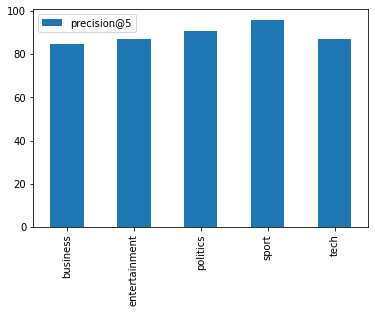

In [18]:
import pandas as pd

df_p5 = pd.DataFrame.from_dict(p5_tfidf, orient='index', columns=['precision@5'])

df_p5["target"] = list(set(y_test))

d = df_p5.set_index("target")

df_p5.plot.bar()

Vemos unos resultados muy buenos con una precisión muy alta. Los porcentajes de precisión varían entre el 85% y el 95%, aproximadamente. Estos son valores muy buenos.

La categoría de deportes es la que mejor precisión tiene con bastante diferencia. Esto se debe a que seguramente se use vocabulario muy específico, ya que será complicado por ejemplo encontrar la palabra _gol_ en el resto de categorías.

Las categorías con peor precisión son las de tecnología y negocios, seguramente por lo contrario al caso anterior. Usarán vocabulario más genérico o más compartido entre ellas. Por ejemplo, la palabra _Excel_ podría estar perfectamente en cualquiera de las dos categorías, refiriendose a una fuente de información económica (negocios) o a una actualización del software (tecnología).

A pesar de estas pequeños fallos en la precisión, los resultados obtenidos son muy buenos.

## 3) Representación basada en word-embeddings y tf-idf

La segunda vectorización que vamos a usar representará los mensajes usando usando word-embeddings usando como pesos la frecuencia de aparición de cada palabra. Al igual que en el apartado anterior, usaremos monogramas y las _stop words_ que vienen configuradas por defecto para el inglés. Recuerda usar como vocabulario para vectorizar el vocabulario del fichero con las word-embeddings.

Aplica la vectorización a los conjuntos de mensajes de entrenamiento y test.

Calcula la precisión@5 de cada una de las clases usando como consultas los documentos de la partición de test y la similitud del coseno. Vamos a considerar que un documento recuperado es relevante cuando pertenezca a la misma clase que la consulta.

Dibuja los resultados en un diagrama de barras y compara los resultados con los del apartado anterior.

#### Solución:

Vamos crear el modelo de word-embedding

In [19]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# Traducimos el fichero glove a un fichero con formato word2vec
glove_file = 'glove.6B.50d.txt'

model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

Usaremos como vocabulario solamente las palabras presentes en la word-embedding

In [20]:
we_vocabulary = list(model.key_to_index.keys())

print(we_vocabulary[0:100])

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as', 'it', 'by', 'at', '(', ')', 'from', 'his', "''", '``', 'an', 'be', 'has', 'are', 'have', 'but', 'were', 'not', 'this', 'who', 'they', 'had', 'i', 'which', 'will', 'their', ':', 'or', 'its', 'one', 'after', 'new', 'been', 'also', 'we', 'would', 'two', 'more', "'", 'first', 'about', 'up', 'when', 'year', 'there', 'all', '--', 'out', 'she', 'other', 'people', "n't", 'her', 'percent', 'than', 'over', 'into', 'last', 'some', 'government', 'time', '$', 'you', 'years', 'if', 'no', 'world', 'can', 'three', 'do', ';', 'president', 'only', 'state', 'million', 'could', 'us', 'most', '_', 'against', 'u.s.']


Con el CountVectorizer calcularemos la frecuencia de las palabras que aparecen en cada documento. Para evitarnos tener que elminar las palabras que no pertenecen a la word-embedding, le pasaremos al CountVectorizer las palabras que queremos que reconozca mediante el atributo vocabulary.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
we_vectorizer = CountVectorizer(vocabulary = we_vocabulary,
                                stop_words = 'english',
                                binary = False, # frecuencia de aparición (NO simplemente si aparece o no)
                                lowercase = False, # para considerar palabras del texto en mayusucla
                                ngram_range=(1,1)) # solo monogramas

In [22]:
train_we = we_vectorizer.fit_transform(X_train)

In [23]:
train_we.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Vamos a definir una función que nos permita calcular los vectores medios de cada documento a partir del word-embedding:

In [24]:
from scipy.sparse import find


def create_doc_embedding (doc_matrix_word_freq, keyedvectors):
    """
    create_doc_embedding creates a doc-embedding matrix where rows are the 
    documents and columns are the dimensions of the word-embedding. Each row r
    summarizes the vectors of the word-embeddings present in document r

    :param doc_matrix_word_freq: frequency matrix of the terms in each document
            It admits binary values, frequencies or weights.
            It admits the output of vectorizer.fit_transform
    :param keyedvectors: keyedvectors object from Gensim which has the 
            word-embedding information
    :return: returns the doc-embedding matrix that summarizes the 
             vector-embeddings of the words present in each document
    """ 

    
    num_docs, num_words= doc_matrix_word_freq.get_shape()

    # Creamos la matriz de documentos con tantas columnas como dimensiones tiene el we 
    doc_embed_matrix = np.zeros([num_docs,keyedvectors.vector_size])


    # Obtenemos los documentos
    docs, col, val = find(doc_matrix_word_freq)
    docs = np.unique(docs)

    # Para cada documento (esto se podrá hacer de forma más pythonica)
    for doc in docs:
      # Obtenemos las palabras presentes en el documento y su frecuencia
      row, words, frecs = find(doc_matrix_word_freq[doc,:])

      # Calculamos el vector medio para el documento
      # Para ello recuperamos los vectores del we presentes en el documento y 
      # los promediamos teniendo en cuenta su frecuencia
      count = 0
      for w,f in zip(words,frecs):
        doc_embed_matrix[doc,:] = doc_embed_matrix[doc,:] + (keyedvectors[w] * f)
        count = count +1
      doc_embed_matrix[doc,:] = doc_embed_matrix[doc,:]/count
    
      
    return doc_embed_matrix

Ahora vamos a calcular los vectores medios de cada documento:

In [25]:
train_embeding = create_doc_embedding(train_we, model)

In [26]:
# Hacemos lo mismo pero para el conjunto de test:
# IMPORTANTE: Para el conjunto de test no hace falta el "fit", ya que vamos a usar solo las palabras
# encontradas en el conjunto de entrenamiento, por lo que haremos solo "transform"
test_we = we_vectorizer.transform(X_test)
# Calculamos también los vectores medios de cada documento
test_embeding = create_doc_embedding(test_we, model)

Vamos a realizar el cálculo y análisis de la precisión@5.

In [27]:
p5_we = mean_precisions_per_class(train_embeding, y_train, test_embeding, y_test, 5)
p5_we

{'business': 88.35820895522389,
 'entertainment': 96.72727272727273,
 'politics': 93.45454545454545,
 'sport': 100.0,
 'tech': 93.84615384615384}

Para facilitar el análisis y lectura de estos resultados, vamos a dibujarlos en un diagrama de barras.

<AxesSubplot:>

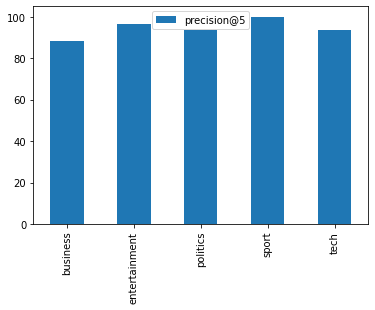

In [28]:
import pandas as pd

df_p5 = pd.DataFrame.from_dict(p5_we, orient='index', columns=['precision@5'])

df_p5["target"] = list(set(y_test))

d = df_p5.set_index("target")

df_p5.plot.bar()

Si analizamos los resultados, vuelven a ser muy buenos, incluso mejor que los anteriores. Notamos una mejoría proporcional en la clasificación de todas las categorías que, aunque sea leve, es una mejoría importante teniendo en cuenta lo cerca que estamos del 100%.

Como se ha visto en la teoría, las word-embeddings van a reducir los vectores a solo uno por cada texto, que será el vector medio, y si multiplicamos los vectores de palabras por su TF-IDF para luego reducirlos al vector medio, estamos evitando la maldición de la dimensionalidad, que en el caso de bolsa de palabras es enorme. Es por eso que tiene sentido un incremento en la calidad de las soluciones.

## 4) Análisis de errores

Vamos a investigar los resultados para entender mejor dónde están fallando los procesos de recuperación. Sigue los siguientes pasos.


1. Identifica la categoría de noticias donde la precisión media haya mejorado más al incorporar word-embeddings
2. Para dicha categoría, identifica la consulta donde la precisión haya mejorado más al usar word-embeddings
3. Muestra el texto original de la consulta y los términos que aparecen en las dos vectorizaciones tf-idf que usamos (recuerda que usamos diccionarios distintos para las vectorizaciones bolsa de palabras y word-embeddings).
4. Identifica las noticias recuperadas para dicha consulta para las dos aproximaciones y sus categorías (TF-IDF puro y con word-embeddings)
5. Muestra la intersección de términos entre la consulta y la primera noticia mal recuperada usando TF-IDF puro.
6. Muestra la intersección de términos entre la consulta y la última noticia bien recuperada usando word-embeddings.
7. A la luz de todo lo anterior, razona sobre por qué crees que el TF-IDF no fue capaz de clasificar bien la noticia y el word-embedding sí.


Puedes usar el código que calcula la intersección de términos que ponemos a continuación

In [29]:
def terms_in_message(feature_names,vector_data,index):
    '''
    Devuelve un conjunto los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    mensaje=vector_data[index,:]>0
    terminos_presentes = ma.array(feature_names, mask = ~(mensaje[0].toarray()))

    return set(terminos_presentes.compressed())

#### Solución:

Vamos a analizar la mejora en la precisión en cada una de las categorías al incorporar word-embeddings

In [30]:
for k in p5_we.keys():
    print("{} improves: {}%".format(k, p5_we[k] - p5_tfidf[k]))

business improves: 3.5820895522388128%
entertainment improves: 9.454545454545467%
politics improves: 2.5454545454545467%
sport improves: 4.05797101449275%
tech improves: 6.92307692307692%


Observamos que la mayor mejora se encuentra en la categoría `entertainment`. Ahora vamos a buscar en qué consulta de esa categoría se produce la mayor mejora:

In [31]:
def precisions_at_class(X_train, y_train, X_test, y_test, k, queryClass):
    '''Devuelve las precision@k media para cada una de las classes.
    
    Parámetros:
    - X_train: documentos de entrenamiento vectorizados.
    - y_train: etiquetas de los documentos de entrenamiento.
    - X_test: documentos vectorizados que se usan como consultas
    - y_test: etiquetas de los documentos que se usan como consultas
    - k: número de documentos considerados a recuperar por la consulta
    - queryClass: clase de documentos considerados a recuperar por la consulta
    
    Devuelve:
    - Diccionario clase -> precisión en tanto por ciento.
    '''
    
    # diccionario categoría -> lista de precisiones
    y_precisions = []
    
    # Calcular precision@k para cada consulta
    for x_query, y_query in zip(X_test, y_test):
        if y_query == queryClass:
            idx = knn(x_query, X_train, k)
            y_selected = np.take(y_train, idx)
            precision = precision_at_k(y_selected, y_query, k)
            y_precisions.append(precision)
    
    return (y_precisions, y_precisions.index(min(y_precisions)))

In [32]:
precisions, worstIndex = precisions_at_class(train_preprocessed, y_train, test_preprocessed, y_test, 5, "entertainment")
print("Mean precision: {}".format(sum(precisions)/len(precisions)))
print("Worst precision: {}".format(min(precisions)))
print("Worst query index: {}".format(worstIndex))

Mean precision: 87.27272727272727
Worst precision: 0.0
Worst query index: 50


La query con peor precisión se encuentra en la posición 50 de las queries de `entertainment`, pero queremos saber su posición global en la queries:

In [33]:
list(X_test).index([q for (i,q) in enumerate(X_test) if y_test[i] == "entertainment"][50])

270

Ahora que sabemos su posición, podemos mostrar la query y su vectorización:

In [34]:
# Vectorización con bolsa de palabras
write_terms(feature_names, X_test, test_preprocessed, 270)

Mensaje 270 SIN vectorizar: singer ian brown  in gig arrest  former stone roses singer ian brown was arrested after a fight during a concert in san francisco on tuesday  his spokesman has said.  a fan jumped on stage and attacked the singer  who then became involved in a fracas with a security guard  fiction records spokesman paul smernicki said. he said brown was arrested at his hotel after the show at the great american music hall but released without charge. san francisco police said they could find no record of his arrest. mr smernicki said he had been told a fan  rugby-tackled  the singer during the gig  which resulted in  pushing and shoving .  brown then got into a brawl with another man who tried to restrain him - without realising he was a security guard  mr smernicki added. the star went off for 15 minutes before returning to finish his set. police took witness statements and apprehended brown at his hotel  mr smernicki said. but he was released without charge and  as far as 

In [35]:
# Vectorización con word-embeddings
vector = []
for word in X_test[270].split():
    if word in we_vocabulary:
        vector.append(word)
print("Mensaje 270 vectorizado: {}".format(vector));

Mensaje 270 vectorizado: ['singer', 'ian', 'brown', 'in', 'gig', 'arrest', 'former', 'stone', 'roses', 'singer', 'ian', 'brown', 'was', 'arrested', 'after', 'a', 'fight', 'during', 'a', 'concert', 'in', 'san', 'francisco', 'on', 'tuesday', 'his', 'spokesman', 'has', 'said.', 'a', 'fan', 'jumped', 'on', 'stage', 'and', 'attacked', 'the', 'singer', 'who', 'then', 'became', 'involved', 'in', 'a', 'fracas', 'with', 'a', 'security', 'guard', 'fiction', 'records', 'spokesman', 'paul', 'said.', 'he', 'said', 'brown', 'was', 'arrested', 'at', 'his', 'hotel', 'after', 'the', 'show', 'at', 'the', 'great', 'american', 'music', 'hall', 'but', 'released', 'without', 'san', 'francisco', 'police', 'said', 'they', 'could', 'find', 'no', 'record', 'of', 'his', 'mr', 'said', 'he', 'had', 'been', 'told', 'a', 'fan', 'the', 'singer', 'during', 'the', 'gig', 'which', 'resulted', 'in', 'pushing', 'and', 'shoving', '.', 'brown', 'then', 'got', 'into', 'a', 'brawl', 'with', 'another', 'man', 'who', 'tried', '

Observamos bastantes diferencias en los resultados del mensaje con las distintas vectorizaciones. Si nos fijamos, la vectorización con bolsa de palabras es mucho más restrictiva a la hora de retirar términos de la vectorización al haberle pasado las stop words del inglés.

Es importante darnos cuenta que para las dos vectorizaciones estamos usando diccionarios distintos. Para word-embeddings se vectoriza el texto tal cual está en la noticia pero quitando aquellas palabras que no aparecen en el vocabulario que hemos llamado `we_vocabulary`.

Ahora vamos a identificar las noticias recuperadas para dicha consulta para las dos aproximaciones y sus categorías:

In [36]:
def results_for_Query(X_train, y_train, X_test, y_test, k, data, index):
    '''Devuelve las precision@k media para cada una de las classes.
    
    Parámetros:
    - X_train: documentos de entrenamiento vectorizados.
    - y_train: etiquetas de los documentos de entrenamiento.
    - X_test: documentos vectorizados que se usan como consultas
    - y_test: etiquetas de los documentos que se usan como consultas
    - k: número de documentos considerados a recuperar por la consulta
    
    Devuelve:
    - Diccionario clase -> precisión en tanto por ciento.
    '''
    
    idx = knn(X_test[index], X_train, k)
    x_selected = np.take(data, idx)
    y_selected = np.take(y_train, idx)
    
    return list(zip(idx,x_selected, y_selected))

Primero veamos la consulta usando TF-IDF puro con bolsa de palabras. Viendo los resultados obtenidos previamente, la predicción es que debería dar un resultado muy malo, ya que lo que estamos buscando es una mejoría muy pronunciada al usar word-embeddings:

In [37]:
for (i,n,c) in results_for_Query(train_preprocessed, y_train, test_preprocessed, y_test, 5, X_train, 270):
    print("Index: {}".format(i))
    print("Category: {}".format(c))
    print("New: \n{} \n\n".format(n))

Index: 205
Category: politics
New: 
profile: gordon brown the ultimate prize of 10 downing street may continue to elude him but  as he prepares to deliver a record-breaking ninth budget  gordon brown can at least console himself with the thought that he is the longest serving chancellor of modern times.  he reached that milestone last june  when he overtook david lloyd george  who served for seven years and 43 days between 1908 and 1915. how much longer mr brown will continue in the job is not clear (he once said there are two types of chancellor:  those who fail and those who get out in time. ) there are rumours he will be moved to the foreign office if labour wins the general election. but  for now  mr brown dominates the domestic political scene like few chancellors - or politicians - before him.  gordon brown was born in glasgow on 20 february 1951  the son of a church of scotland minister in the small fife town of kirkcaldy. at 12  he was canvassing for labour and by his 20s he wa

Podemos comprobar que todos los resultados pertenecen a la categoría `politics` en lugar de a `entertainment`, por lo que es lógico que nuestro clasificador decida que nuestra noticia es de `politics` también.

Ahora vamos a mostrar los resultados de la misma query usando word-embeddings para tratar de demostrar la mejoría que comentábamos anteriormente:

In [38]:
for (i,n,c) in results_for_Query(train_embeding, y_train, test_embeding, y_test, 5, X_train, 270):
    print("Index: {}".format(i))
    print("Category: {}".format(c))
    print("New: \n{} \n\n".format(n))

Index: 154
Category: entertainment
New: 
singer knight backs anti-gun song r&b star beverley knight said she sang on an anti-gun single after being  haunted  by the fatal 2003 shooting of two teenage girls in birmingham.  knight and drum  n  bass star roni size have released no more in a bid to reduce gun use among young people. she said she was  horrified  by the deaths of charlene ellis  18  and letisha shakespeare  17. size  whose new forms album won the 1997 mercury music prize  said gun use was  nothing to be glamorised .  there were more than 10 500 firearms offences and 70 gun crime deaths in england and wales between june 2003 and 2004  according to home office figures. knight said the scale of the problem became clear to her after the 2003 shootings in aston  near knight s birmingham home.   it haunted me to be honest  it haunted my sleep   she said. size became involved after two friends  donna small and asha jama  were shot in his bristol hometown in october. jama  25  lost 

Podemos comprobar que la precisión es de un 100%, por lo que el clasificador tomará una buena decisión metiendo nuestra noticia como `entertainment`.

Ahora vamos a mostrar la intersección entre la consulta y la primera noticia mal recuperada usando TF-IDF puro:

In [39]:
words_query = set(terms_in_message(feature_names, test_preprocessed, 270))
words_first_result = set(terms_in_message(feature_names, train_preprocessed, 205))
print(words_query & words_first_result)

{'mr', 'man', 'record', 's', 'far', 'spokesman', 'using', 'brown', 'went', 'career', 'took', 'said'}


Como vemos, hay varias palabras que se repiten en ambas noticias. 

Ahora vamos a mostrar la intersección entre la consulta y la primera noticia bien recuperada usando word-embeddings:

In [40]:
words_query = set(terms_in_message(feature_names, test_preprocessed, 270))
words_first_result = set(terms_in_message(feature_names, train_preprocessed, 1152))
print(words_query & words_first_result)

{'told', 'paul', 'set', 's', 'singer'}


Si observamos los dos resultados anteriores, vemos que hay varias palabras que se repiten en la noticia de la consulta y en las noticias recuperadas como similares. Vamos a analizar por qué el TF-IDF no ha sido capaz de clasificar bien la noticia y el word-embedding sí.

Lo que hace el TF-IDF es asignar un peso a cada término de cada documento, dependiendo de la frecuencia de ese término en ese documento (TF) y de la inversa del número de documentos del total del corpus en los que aparece ese término (IDF). Si nos fijamos en los resultados obtenidos en las dos celdas de código anteriores, vemos que las palabras recuperadas por la intersección de TF-IDF son bastante numerosas en comparación con la intersección de word-embeddings.
Esto se debe a que la clasificación TF-IDF se va a basar en la aparición de las palabras y su frecuencia, y por ese motivo va a recuperar como más relevante aquellos textos que tengan un mayor número de palabras coincidentes en relación a sus pesos. Además, de entre las palabras coincidentes, las que tengan un peso importante en una categoría serán clave para clasificar la noticia de la consulta.
La palabra más clara para ejemplificar esto es el uso de _brown_, que es de mucha relevancia en la categoría _politics_ cuando se habla de Gordon Brown, antiguo Primer Ministro del Reino Unido. Aunque la noticia de la consulta hable sobre Ian Brown (músico y compositor inglés), tiene sentido que en el momento en el que nuestro clasificador detecta la palabra _brown_ se piense que hace referencia a las numerosas veces que se menciona a Gordon Brown en las noticias de la categoría _politics_.

Para este caso en concreto hemos visto que la clasificación fallaba con bolsa de palabras, pero mejoraba a una precisión del 100% con word-embeddings. Lo que hacen las word-embeddings con el transformador TF-IDF es vectorizar cada término de cada noticia, multiplicar el vector por el TF-IDF de ese término y unificar los vectores en uno solo, al que conocemos como vector medio. Este vector medio representará los valores medios de esa noticia en cada dimension del word-embeding. 

Es por eso que en vez de solamente considerar la presencia de ciertas palabras en una noticia, logramos caracterizar el contenido del documento en las dimensiones del word-embeding. Esto nos brinda principalmente dos ventajas. 

Por un lado, encontraremos relacion entre palabras nuevas y otras propias a la query. De esta forma, si en una query aparece la palabra "futbol", los word-embeding nos permitirán establecer una relación con documentos en los que aparezcan otros deportes como "baloncesto" o "tenis", o incluso un sinónimo como "balompié". Estas relaciones no serían detectables si solo contaramos con la informacion que nos proporciona TF-IDF. Es por este motivo por el que vemos que la word-embedding consigue clasificar con éxito la noticia a pesar de tener tan solo 5 palabras en común gracias a la relación y significado de los términos encontrados.

Por otro lado, al participar todas las palabras en la caracterización del documento, la presencia de una única en palabra común con la query no tiene tanta importancia como si usaramos la bolsa d epalabras. Gracias a no dar tanta importancia a palabras sueltas, evitamos que palabras con gran relevancia en una categoría decidan la categorización de esa noticia como pasaba en el caso anterior con la palabra _brown_. 